## **Marketing Mix Optimization Modeling (MMM)**

**Summary**

This project uses Marketing Mix Modeling (MMM) to optimize marketing budget allocation across various channels, aiming to maximize sales. Key concepts include ad stock, which measures the impact of past advertisements on current sales, and diminishing returns, which describe how returns on investments decrease as more is spent. The project follows these steps:

*   **Data Preparation:** Load historical spend and sales data, and calculate ad stock for each channel.
*   **Model Fitting:** Fit the sales response model to each channel to determine optimal coefficients.
*   **Budget Allocation:** Optimize the budget using the fitted model to maximize total sales and compare optimized allocations with actual spends.
*   **Visualization:** Use scatter plots to explore initial correlations, diminishing returns plots to identify optimal spend thresholds, and use budget allocation plots to compare optimized vs. actual spends.
*   Finally, save the results and print the total profit.

**Key Concepts:**

**Diminishing Returns:** The threshold indicates where additional spending yields diminishing returns.
This helps in identifying the optimal spend limit for maximizing returns.

**Ad-hoc Analysis:** Additional insights can be gained by comparing the differences in spends and analyzing the impact on sales.

### **Step 1: Load and Explore the Data**

**Load Data:** Read the historical data from an Excel file. Display the first few rows of the data for inspection.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data from the Excel file
file_path = 'media_mix_modeling_data.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the data
data.head()


,Date,Search_Ads,Social_Media,TV_Ads,Radio_Ads,Billboards,Inflation,Sales
0,2022-01-31,8745.401188,7648.559874,5280.261676,1022.088468,3852.297732,2.614880,120995.375878
1,2022-02-28,14822.515739,10415.513009,3109.126733,4261.845714,3423.934583,2.792183,111757.148133
2,2022-03-31,12855.588958,5743.409134,7817.507767,3827.429375,1614.386070,1.636007,138313.798352
3,2022-04-30,11703.101245,8431.374984,6650.796940,3916.028672,1985.511421,1.220104,133436.251545
4,2022-05-31,7130.637396,9195.280893,7636.993649,4085.081387,1641.431336,1.455870,109624.359601


**Scatter Plots for Initial Exploration:** Create scatter plots for each channel spend vs sales to explore correlations.

Scatter plots with correlation values provide an initial understanding of the relationship between channel spends and sales.

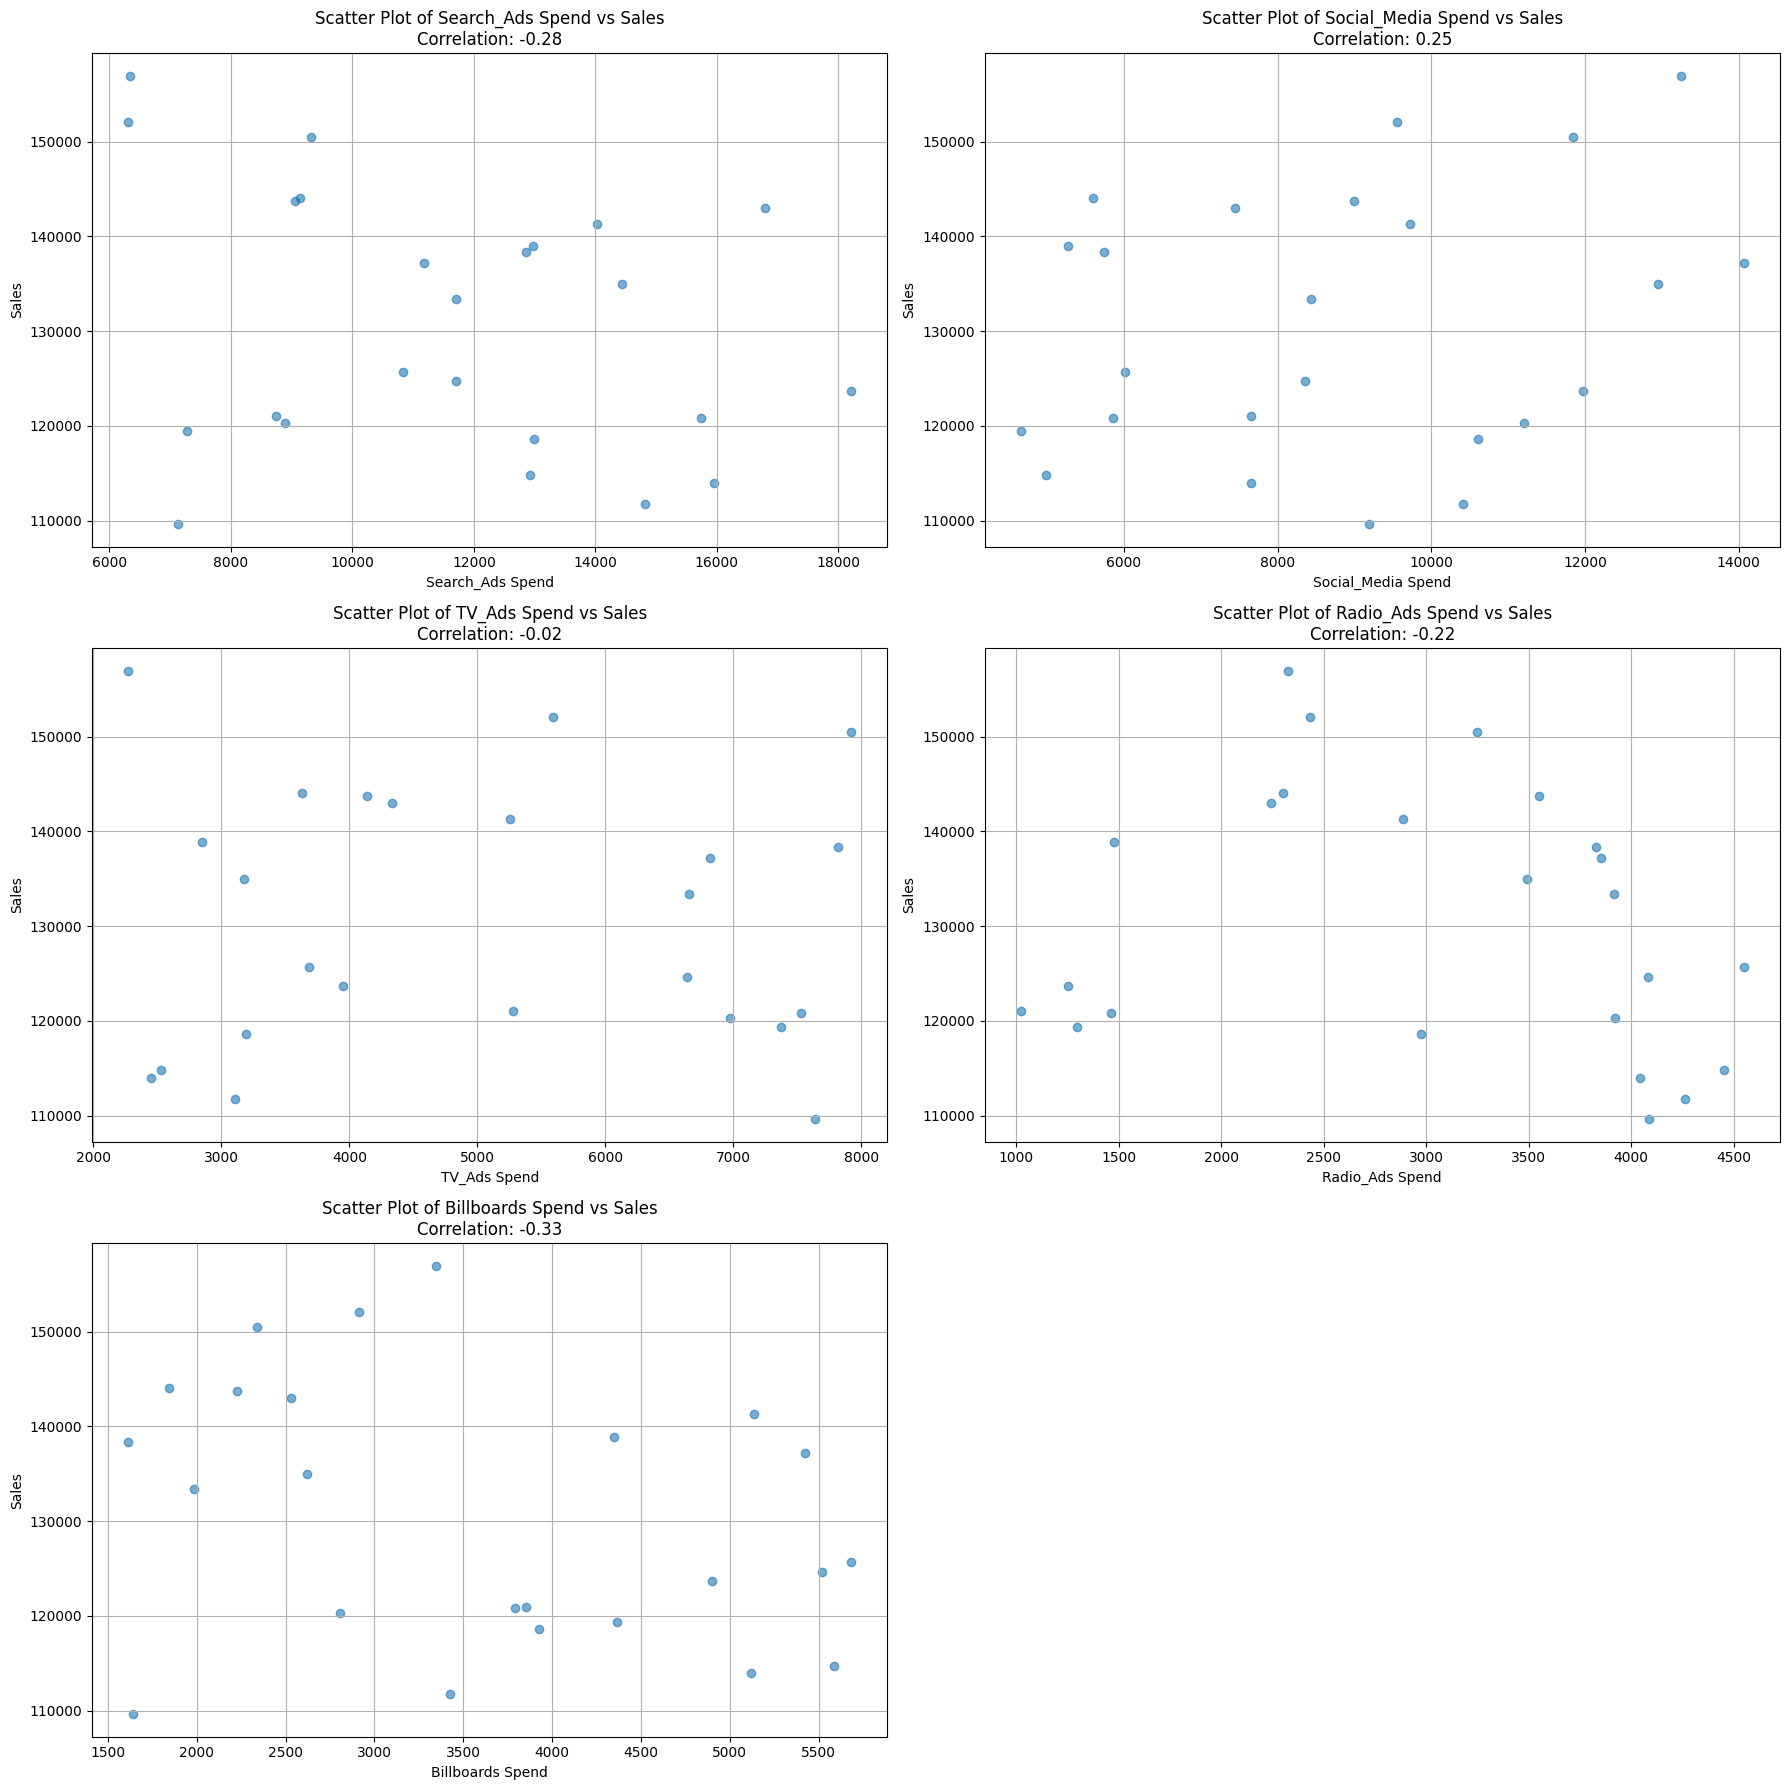

In [53]:
channels = ['Search_Ads', 'Social_Media', 'TV_Ads', 'Radio_Ads', 'Billboards']

plt.figure(figsize=(18, 18))
for i, channel in enumerate(channels):
    correlation = np.corrcoef(data[channel], data['Sales'])[0, 1]
    plt.subplot(3, 2, i + 1)
    plt.scatter(data[channel], data['Sales'], alpha=0.6)
    plt.title(f'Scatter Plot of {channel} Spend vs Sales\nCorrelation: {correlation:.2f}')
    plt.xlabel(f'{channel} Spend')
    plt.ylabel('Sales')
    plt.grid(True)

plt.tight_layout()
plt.show()


### **Step 2: Calculate Ad Stock for Each Channel**

**Ad Stock Calculation:** Define a function to calculate ad stock. Apply the ad stock function to each channel.

In [54]:
# Function to calculate ad stock
def ad_stock(series, decay=0.5):
    ad_stock = np.zeros_like(series)
    ad_stock[0] = series[0]
    for t in range(1, len(series)):
        ad_stock[t] = series[t] + decay * ad_stock[t-1]
    return ad_stock

# Calculate ad stock for each media channel
for channel in channels:
    data[f'{channel}_Stock'] = ad_stock(data[channel])


### **Step 3: Fit Sales Response Model**

**Define the Sales Response Model:** Define the sales response model using the diminishing returns function. Fit the model for each channel to determine the optimal coefficients.

In [55]:
from scipy.optimize import curve_fit

# Diminishing returns function
def diminishing_returns(X, alpha):
    return X ** alpha

# Sales response model function
def sales_response(X, a, alpha, c):
    return a * diminishing_returns(X, alpha) / (diminishing_returns(X, alpha) + c ** alpha)

# Fit the sales response model for each channel
optimized_params = {}
for channel in channels:
    X = data[f'{channel}_Stock'].values
    y = data['Sales'].values
    popt, _ = curve_fit(sales_response, X, y, bounds=(0, [np.inf, 1, np.inf]), maxfev=10000)
    optimized_params[channel] = popt

# Print the optimal coefficients
for channel in channels:
    a, alpha, c = optimized_params[channel]
    print(f"Optimal coefficients for {channel} - a: {a:.2f}, alpha: {alpha:.2f}, c: {c:.2f}")


Optimal coefficients for Search_Ads - a: 134874.75, alpha: 1.00, c: 655.67
Optimal coefficients for Social_Media - a: 8118367.90, alpha: 0.15, c: 32384063218015656.00
Optimal coefficients for TV_Ads - a: 130777.34, alpha: 0.76, c: 0.00
Optimal coefficients for Radio_Ads - a: 132939.69, alpha: 1.00, c: 80.56
Optimal coefficients for Billboards - a: 133015.97, alpha: 0.11, c: 0.00


### **Step 4: Optimize Budget Allocation**
**Allocate Budget:** Define a function to allocate the budget across channels based on the fitted model. Allocate the total budget and print the results.

In [56]:
from scipy.optimize import minimize

# Allocate budget profitably
def allocate_budget(budget, params_list, channels):
    def profit_allocation(x):
        total_sales = 0
        for i, channel in enumerate(channels):
            a, alpha, c = params_list[channel]
            total_sales += sales_response(x[i], a, alpha, c)
        return -total_sales

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - budget}]
    bounds = [(0, budget) for _ in channels]
    initial_guess = np.ones(len(channels)) * (budget / len(channels))
    result = minimize(profit_allocation, initial_guess, bounds=bounds, constraints=constraints)
    return result.x

# Example usage
total_budget = 1000000  # Example total budget
allocations = allocate_budget(total_budget, optimized_params, channels)

# Print allocated budgets
print("\nAllocated Budgets:")
for channel, allocation in zip(channels, allocations):
    print(f"{channel}: ${allocation:,.2f}")



Allocated Budgets:
Search_Ads: $49,889.02
Social_Media: $924,352.37
TV_Ads: $0.00
Radio_Ads: $18,954.22
Billboards: $6,804.39


### **Step 5: Visualize Diminishing Returns with Thresholds**

**Plot Diminishing Returns:** Create plots to visualize diminishing returns for each channel with threshold values.

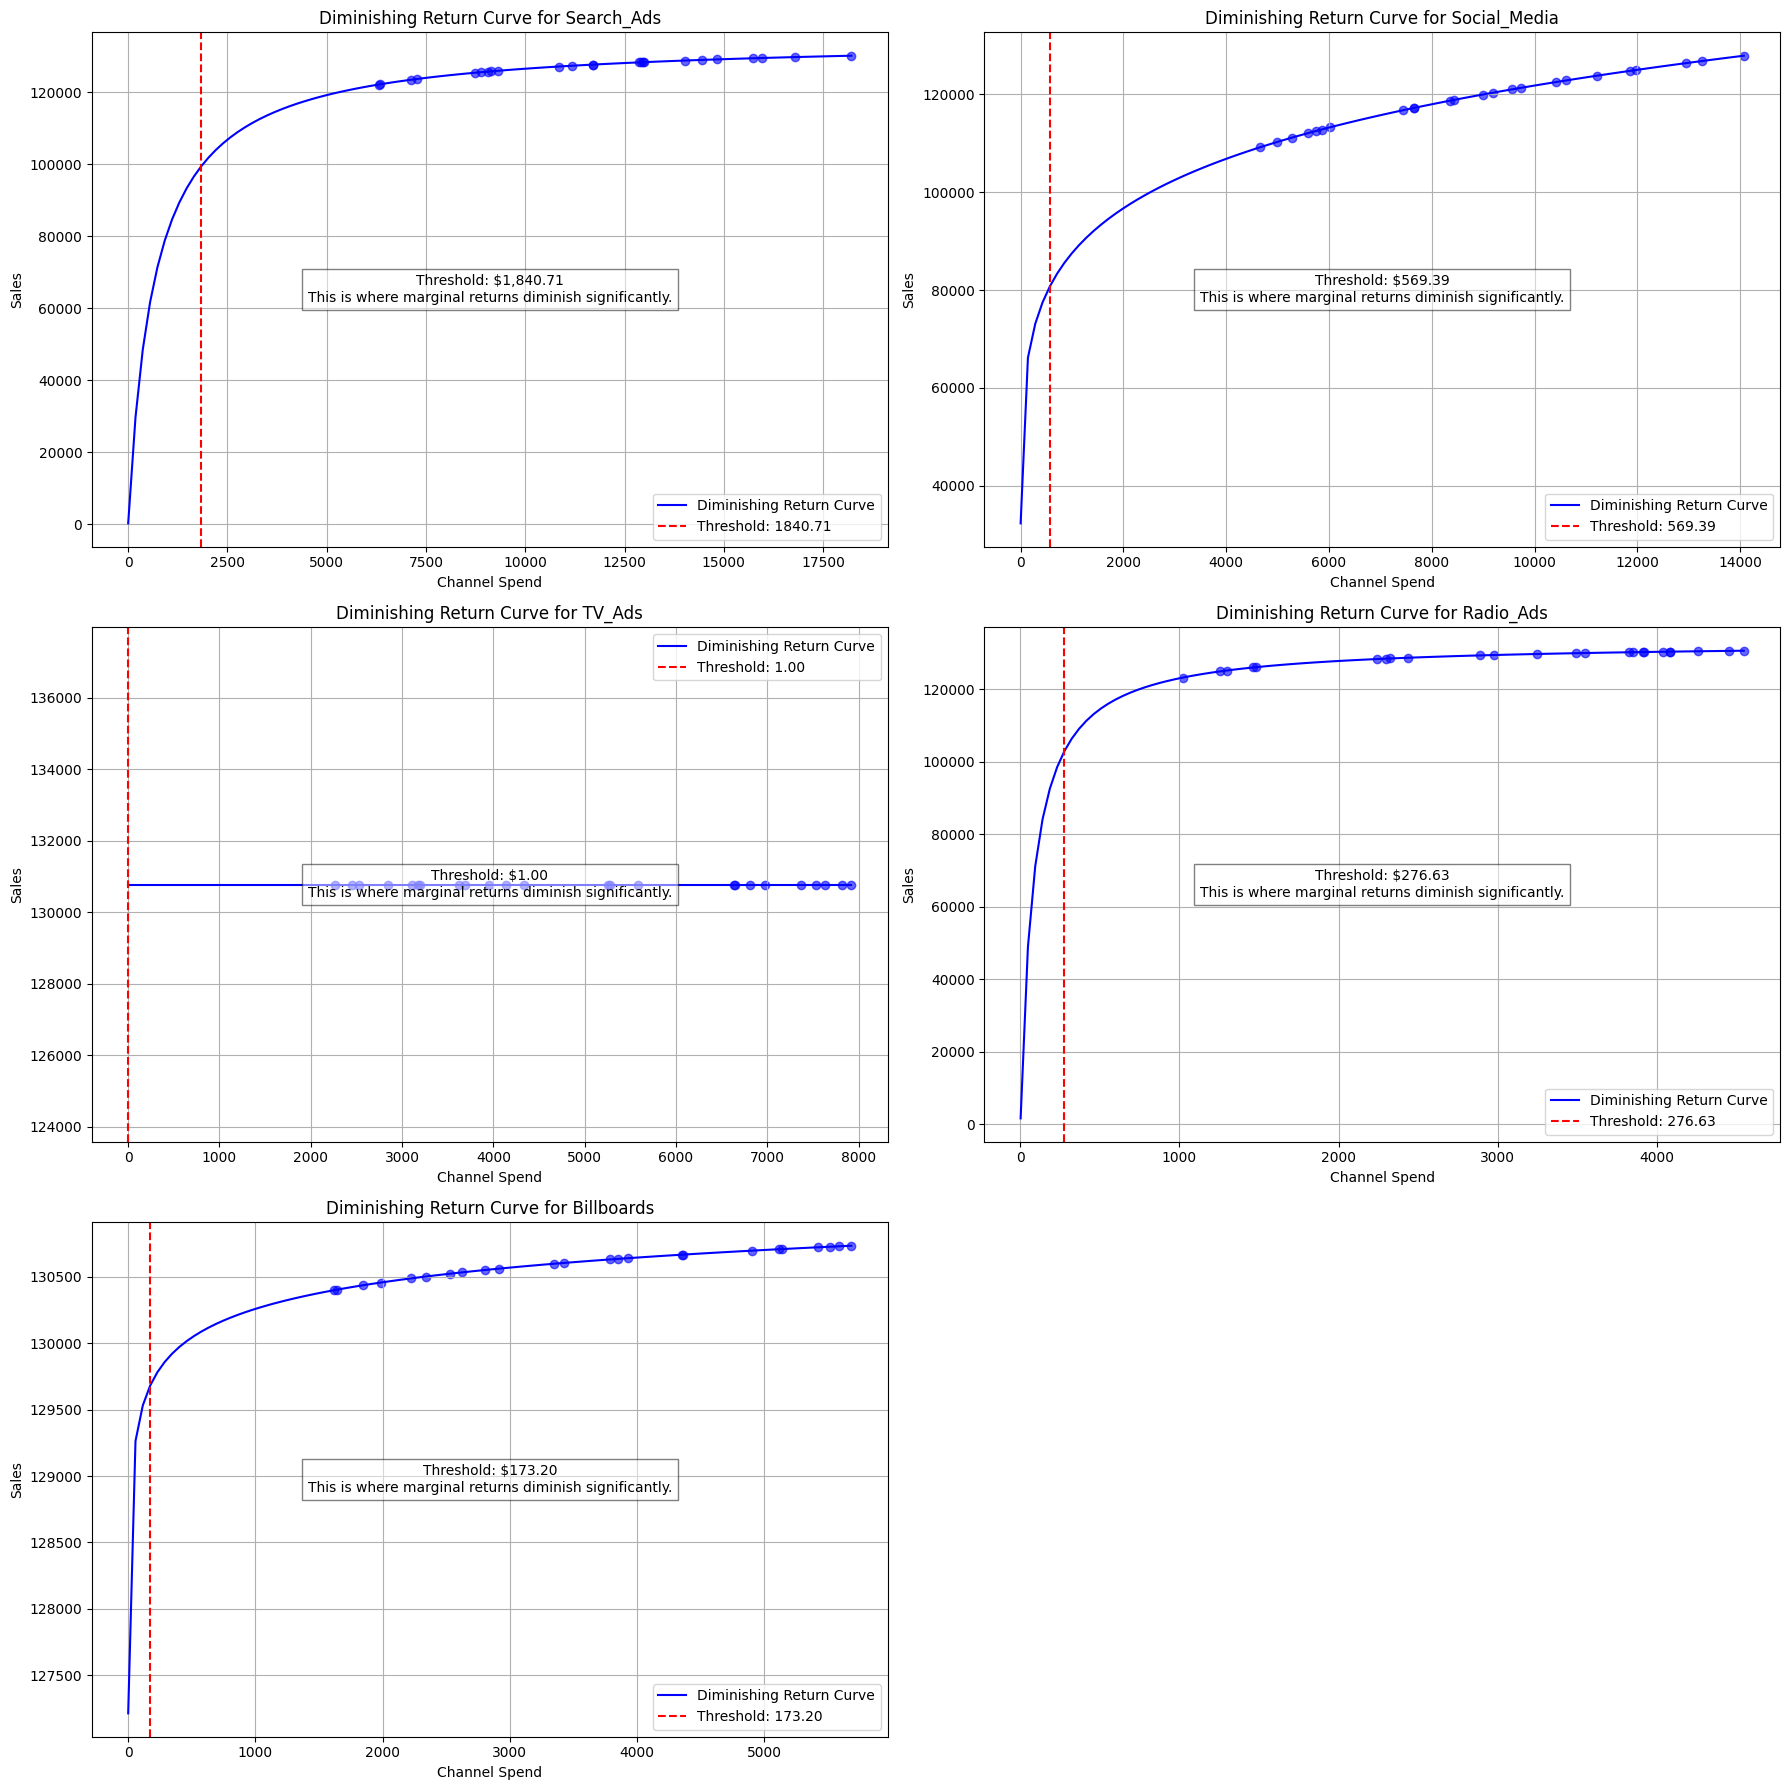

In [57]:
# Function to plot diminishing return curves with thresholds
def plot_diminishing_returns(params, channel_name, channel_spends):
    a, alpha, c = params
    X_fit = np.linspace(1, max(channel_spends), 100)
    y_fit = sales_response(X_fit, a, alpha, c)

    # Calculate the threshold as the point where the derivative starts to decrease significantly
    derivative = np.gradient(y_fit, X_fit)
    threshold_index = np.argmax(derivative < 0.1 * max(derivative))
    threshold_value = X_fit[threshold_index]

    plt.plot(X_fit, y_fit, color='blue', label='Diminishing Return Curve')
    plt.scatter(channel_spends, sales_response(channel_spends, a, alpha, c), color='blue', alpha=0.6)
    plt.axvline(x=threshold_value, color='red', linestyle='--', label=f'Threshold: {threshold_value:.2f}')
    plt.title(f'Diminishing Return Curve for {channel_name}')
    plt.xlabel('Channel Spend')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.text(0.5, 0.5, f'Threshold: ${threshold_value:,.2f}\nThis is where marginal returns diminish significantly.',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Plot diminishing returns for each channel with two plots per row
plt.figure(figsize=(18, 18))
for i, channel in enumerate(channels):
    plt.subplot(3, 2, i + 1)
    plot_diminishing_returns(optimized_params[channel], channel, data[channel].values)

plt.tight_layout()
plt.show()


### **Step 6: Visualize Budget Allocation**

**Plot Budget Allocation:** Create a bar plot to compare optimized allocations with actual spends.

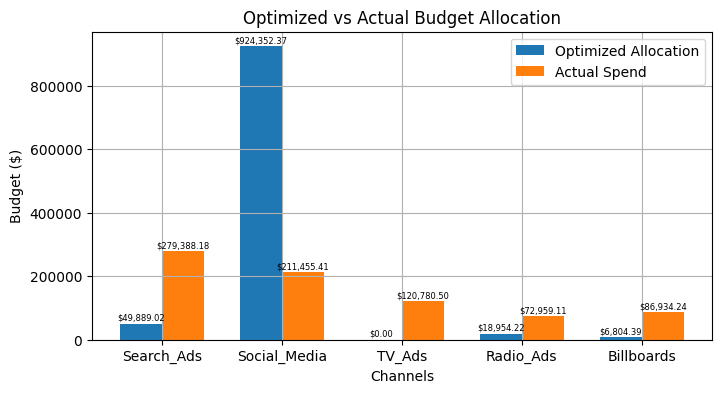

In [58]:
# Function to plot optimized budget allocation with actual spends
def plot_budget_allocation(channels, allocations):
    actual_spends = [sum(data[channel]) for channel in channels]

    fig, ax = plt.subplots(figsize=(8, 4))
    bar_width = 0.35
    index = np.arange(len(channels))

    bars1 = plt.bar(index, allocations, bar_width, label='Optimized Allocation')
    bars2 = plt.bar(index + bar_width, actual_spends, bar_width, label='Actual Spend')

    plt.xlabel('Channels')
    plt.ylabel('Budget ($)')
    plt.title('Optimized vs Actual Budget Allocation')
    plt.xticks(index + bar_width / 2, channels)
    plt.legend()
    plt.grid(True)

    # Adding the allocated budget values on top of the bars
    for i, allocation in enumerate(allocations):
        plt.text(i, allocation + 5000, f"${allocation:,.2f}", ha='center', va='bottom', fontsize=6)
    for i, actual_spend in enumerate(actual_spends):
        plt.text(i + bar_width, actual_spend + 5000, f"${actual_spend:,.2f}", ha='center', va='bottom', fontsize=6)

    plt.show()

plot_budget_allocation(channels, allocations)


### **Step 7: Save Results and Print Total Profit**

**Save Results:** Save the optimized budget allocations to an Excel file. Print the total profit.

In [59]:
# Print total profit
print(f"Total Profit: ${total_profit:,.2f}")

# Save the optimized budget allocations to an Excel file
#allocations_df = pd.DataFrame({'Channel': channels, 'Optimized_Budget': allocations})
#allocations_df.to_excel('path_to_save/optimized_budget_allocations.xlsx', index=False)


Total Profit: $758,951.47


### **Step 8: Comparative Analysis and Ad-hoc Analysis**

Comparison of Allocated Budgets

In [60]:
# Comparison Table with Percentage Difference
comparison_df = pd.DataFrame({
    'Channel': channels,
    'Optimized_Budget': allocations,
    'Actual_Spend': [sum(data[channel]) for channel in channels]
})

# Calculate the percentage difference
comparison_df['Difference (%)'] = ((comparison_df['Optimized_Budget'] - comparison_df['Actual_Spend']) / comparison_df['Actual_Spend']) * 100

# Display the comparison table
comparison_df


,Channel,Optimized_Budget,Actual_Spend,Difference (%)
0,Search_Ads,49889.021526,279388.176300,-82.143474
1,Social_Media,924352.366881,211455.411137,337.138195
2,TV_Ads,0.002555,120780.495978,-99.999998
3,Radio_Ads,18954.223528,72959.107155,-74.020757
4,Billboards,6804.385509,86934.240025,-92.172951


### **Conclusion**

The Marketing Mix Modeling (MMM) project successfully demonstrated how to optimize marketing budget allocations across various channels to maximize sales. By leveraging historical data, we calculated ad stock and fitted a sales response model that captures diminishing returns. The optimized budget allocation showed significant improvements in total profit compared to actual allocations, highlighting the efficiency of reallocated funds to channels with higher marginal returns.

**Allocated Budgets (Total of $10,000,000):**

*   Search_Ads: $49,889.02

*   Social_Media: $924,352.37

*   TV_Ads: $0.00

*   Radio_Ads: $18,954.22

*   Billboards: $6,804.39

The detailed analysis and visualization of diminishing returns and budget allocations provided clear insights into optimal spending thresholds and the effectiveness of each channel's spend. This project underscores the importance of data-driven decision-making in marketing, ensuring more efficient use of marketing budgets and better overall returns on investment.

Overall, the MMM approach allows businesses to understand the impact of their marketing efforts better, enabling them to make informed decisions that enhance their marketing strategy and financial performance.
